In [3]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:98% !important;}</style>'))

In [4]:
### Necessary libraries
import warnings
import pandas as pd
import numpy as np
import time
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn.metrics import accuracy_score,log_loss
import matplotlib.pylab as plt
import seaborn as sns

### Seaborn style
sns.set_style("whitegrid")
import jaydebeapi
import os


In [5]:
topo = pd.read_csv("uc7_topo_density.csv",sep=';',encoding = "utf-8")
topo.head()

,cell,density_lon_row,density_lat_row,density
0,257-3091-2G,101,155,0.02426
1,257-40641-2G,102,155,0.02164
2,257-42260-2G,102,155,0.02164
3,257-44252-2G,102,155,0.02164
4,257-58301-2G,102,155,0.02164


In [6]:
train = pd.read_csv("dlj_train.zip",sep=';',compression='zip')
train.shape

C:\Applications\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6,7,11,15,18,19,26,27,28,30,31,32,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(10039826, 40)

In [7]:
test = pd.read_csv("dlj_test.zip",sep=';',compression='zip')
test.shape

C:\Applications\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (27,28,31,32,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2550463, 40)

In [8]:
train = train.merge(topo,left_on='cell',right_on='cell', how='left')

In [9]:
test = test.merge(topo,left_on='cell',right_on='cell', how='left')

In [10]:
train['liste_type']=train['liste_type'].replace(['Autoroute','Train','Autres','Train,Autoroute', 'Autoroute,Train'],[0,1,2,1,0])
train['liste_type'].unique()

array([1, 2, 0], dtype=int64)

In [ ]:
features = [x for x in train.columns if x not in ['uid','imsi','liste_type','cell']]
print(features)
train_x = train[features]
train_y = train['liste_type']
test_x = test[features]
test_y = test['liste_type']

In [18]:
warnings.filterwarnings('ignore')
train_x = train_x.convert_objects(convert_numeric=True)
test_x = test_x.convert_objects(convert_numeric=True)

In [19]:
train_x["vitesse1"] =train_x["distance_cell_celllag1b"] / train_x["delta_lag1_date_session"]
train_x["vitesse2"] =train_x["distance_cell_celllag1b"] / train_x["delta_lead1_date_session"]
train_x["vitesse3"] =train_x["distance_cell_celllead1b"] / train_x["delta_lag1_date_session"]
train_x["vitesse4"] =train_x["distance_cell_celllead1b"] / train_x["delta_lead1_date_session"]

test_x["vitesse1"] =test_x["distance_cell_celllag1b"] / test_x["delta_lag1_date_session"]
test_x["vitesse2"] =test_x["distance_cell_celllag1b"] / test_x["delta_lead1_date_session"]
test_x["vitesse3"] =test_x["distance_cell_celllead1b"] / test_x["delta_lag1_date_session"]
test_x["vitesse4"] =test_x["distance_cell_celllead1b"] / test_x["delta_lead1_date_session"]


In [62]:
features = [x for x in train_x.columns]
print(features)

['duree', 'nb_event', 'distance_autoroute', 'distance_train', 'lag1_cell_eqal', 'lag1_distance_autoroute', 'lag1_distance_train', 'lag1_duree', 'lead1_cell_egal', 'lead1_distance_autoroute', 'lead1_distance_train', 'lead1_duree', 'distance_cell_celllag1b', 'distance_cell_celllead1b', 'delta_lag1_date_session', 'delta_lead1_date_session', 'annee', 'mois', 'jour', 'is_week', 'heure', 'uniq_cell_by_hour', 'distance_parcourue_by_hour', 'max_distance_train_by_hour', 'max_distance_autoroute_by_hour', 'uniq_cell_by_demiheure', 'distance_parcourue_by_demiheure', 'max_distance_train_by_demiheure', 'max_distance_autoroute_by_demiheure', 'uniq_cell_by_quartheure', 'distance_parcourue_by_quartheure', 'max_distance_train_by_quartheure', 'max_distance_autoroute_by_quartheure', 'proba_auto', 'proba_train', 'proba_autres', 'density_lon_row', 'density_lat_row', 'density', 'vitesse1', 'vitesse2', 'vitesse3', 'vitesse4']


In [20]:
#Handling vacancy values
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [21]:
train_x = train_x.replace([np.inf,-np.inf],0)
test_x = test_x.replace([np.inf,-np.inf],0)

In [ ]:
columns_int = ['duree','nb_event','lag1_cell_eqal','lead1_cell_egal','annee','mois','jour','heure','is_week','uniq_cell_by_hour','uniq_cell_by_demiheure','uniq_cell_by_quartheure']
train_x[columns_int] = train_x[columns_int].astype('int8')

In [ ]:
columns_float = [x for x in train_x.columns if x not in columns_int]
train_x[columns_float] = train_x[columns_float].astype('float16')

In [22]:
train_x.head()

,duree,nb_event,distance_autoroute,distance_train,lag1_cell_eqal,lag1_distance_autoroute,lag1_distance_train,lag1_duree,lead1_cell_egal,lead1_distance_autoroute,...,proba_auto,proba_train,proba_autres,density_lon_row,density_lat_row,density,vitesse1,vitesse2,vitesse3,vitesse4
0,0,1,0.007078,0.005485,0,0.019654,0.004317,0.0,0,0.019654,...,0.0,0.0,0.0,144.0,42.0,0.026114,0.001382,0.000863,0.001382,0.000863
1,0,3,0.007078,0.005485,0,0.011305,0.002597,11.0,0,0.019654,...,0.0,0.0,0.0,144.0,42.0,0.026114,0.001470,0.000401,0.004605,0.001256
2,0,1,0.007078,0.005485,0,0.011305,0.002597,0.0,0,0.011305,...,0.0,0.0,0.0,144.0,42.0,0.026114,0.002205,0.001470,0.002205,0.001470
3,0,1,0.000000,0.000000,0,0.019654,0.004317,69.0,0,0.003756,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,3,3,0.000000,0.000000,0,0.003756,0.003092,0.0,0,0.003756,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
test_x.head()

,duree,nb_event,distance_autoroute,distance_train,lag1_cell_eqal,lag1_distance_autoroute,lag1_distance_train,lag1_duree,lead1_cell_egal,lead1_distance_autoroute,...,proba_auto,proba_train,proba_autres,density_lon_row,density_lat_row,density,vitesse1,vitesse2,vitesse3,vitesse4
0,0,2,0.01535,0.002559,0,0.0000,0.000000,0.0,0,0.009100,...,1.0,0.0,0.0,139.0,52.0,0.022103,0.0000,0.00000,0.001900,0.003800
1,0,2,0.01535,0.002559,0,0.0091,0.004939,0.0,0,0.009100,...,1.0,0.0,0.0,139.0,52.0,0.022103,0.0038,0.00285,0.003800,0.002850
2,0,2,0.01535,0.002559,0,0.0000,0.000000,0.0,0,0.009100,...,1.0,0.0,0.0,139.0,52.0,0.022103,0.0000,0.00000,0.001140,0.011401
3,0,4,0.01535,0.002559,0,0.0000,0.000547,109.0,0,0.043098,...,1.0,0.0,0.0,139.0,52.0,0.022103,0.0000,0.00000,0.000000,0.000000
4,3,7,0.01535,0.002559,0,0.0000,0.000000,0.0,0,0.017555,...,1.0,0.0,0.0,139.0,52.0,0.022103,-0.0000,0.00000,-0.001699,0.000000


## Random Forest Model

In [24]:
#with default parameters
rf = RandomForestClassifier(n_estimators =50 ,max_features = 'sqrt', oob_score = True, verbose = 1, random_state = 123)
rf.fit(train_x,train_y)
print("Out of bags score: ",rf.oob_score_)
print("Accuracy: ",accuracy_score(train_y,rf.predict(train_x)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 47.2min finished


Out of bags score:  0.9981476770613356


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min finished


Accuracy:  0.9999994023800811


##  KFold Cross Validation

In [52]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,log_loss

nr_fold = 5
random_state = 1234
folds = StratifiedKFold(n_splits = nr_fold, 
                            shuffle = True, 
                            random_state = random_state)

In [63]:
warnings.filterwarnings('ignore')
# utilise pour stocker les resultats
oof_preds  = np.zeros((len(train)))

test_preds = []
importances = pd.DataFrame()
clfs = []
start_time=time.time()
    
for fold_, (trn_, val_) in enumerate(folds.split(train,train_y)):

        trn_x, trn_y = train_x.iloc[trn_], train_y.iloc[trn_]
        val_x, val_y = train_x.iloc[val_], train_y.iloc[val_]
    
        clf = RandomForestClassifier(n_estimators = 30,max_features = 'sqrt', oob_score = True, verbose = 1, random_state = 1234)
        clf.fit(trn_x, trn_y)
    
        oof_preds[val_] = clf.predict(val_x)
        test_preds.append(clf.predict(test_x) )  
        imp_df = pd.DataFrame()
        imp_df['feature'] = features
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)
        clfs.append(clf)
        
        fold_accuracy = accuracy_score(val_y, oof_preds[val_])
        fold_logloss = log_loss(val_y,clf.predict_proba(val_x))

        print('RFC Model no {}-fold accuracy_score is {}, LogLoss score is {},'.format(fold_ + 1,fold_accuracy,fold_logloss))
        end_time = time.time()
        print("it takes %.3f seconds to perform cross validation" % (end_time - start_time))
        

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 21.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.2s finished


RFC Model no 1-fold accuracy_score is 0.9982146112035761, LogLoss score is 0.010448161193815194,
it takes 1525.821 seconds to perform cross validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 21.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   14.9s finished


RFC Model no 2-fold accuracy_score is 0.9979690891180428, LogLoss score is 0.011273307046038001,
it takes 3041.480 seconds to perform cross validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 22.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   14.6s finished


RFC Model no 3-fold accuracy_score is 0.9980577350700834, LogLoss score is 0.010817604924693847,
it takes 4560.233 seconds to perform cross validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 20.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   14.4s finished


RFC Model no 4-fold accuracy_score is 0.9980920982188435, LogLoss score is 0.010724054090481749,
it takes 5999.757 seconds to perform cross validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 21.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.4s finished


RFC Model no 5-fold accuracy_score is 0.9980462797141781, LogLoss score is 0.01087161736890404,
it takes 7492.333 seconds to perform cross validation


In [65]:
#Features's importances
def print_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(13, 11))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:100])
    plt.tight_layout()
    plt.savefig('importances_v2.png')
    plt.show()

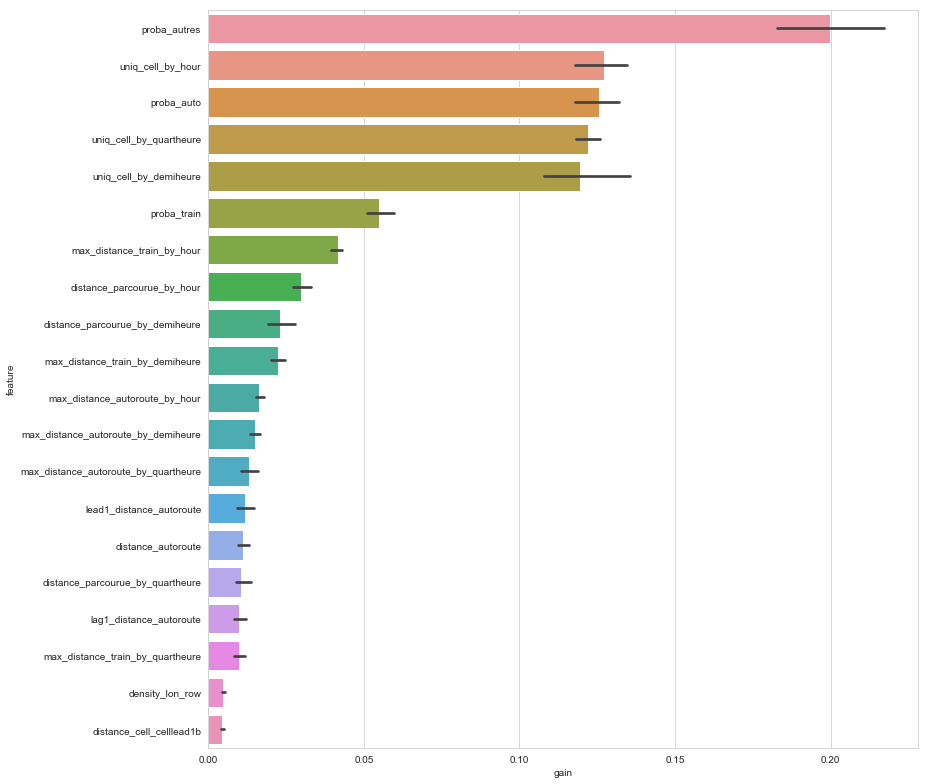

In [66]:
print_importances(importances)

## Validation

In [67]:
print('Accuracy: ',accuracy_score(train_y,oof_preds))

Accuracy:  0.9980759626710662


In [68]:
from sklearn.metrics import classification_report 
target_names = ['Autoroute','Train','Autres']
sampleClassificationReport = classification_report(train_y,oof_preds,target_names = target_names)
print(sampleClassificationReport)

              precision    recall  f1-score   support

   Autoroute       1.00      1.00      1.00   2465229
       Train       1.00      0.99      0.99    812257
      Autres       1.00      1.00      1.00   6762340

   micro avg       1.00      1.00      1.00  10039826
   macro avg       1.00      0.99      1.00  10039826
weighted avg       1.00      1.00      1.00  10039826



In [69]:
def plot_classification_report(cr, title='Classification report ',fontsize=16, with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')
    # print(len(lines))
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 5)]:
        # print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)

    plt.figure(figsize=(10, 8))
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'],fontsize=12)
    plt.yticks(y_tick_marks, classes,fontsize=12)
    plt.tight_layout()
    plt.ylabel('Classes',fontsize=16)
    plt.xlabel('Measures',fontsize=16)

[1.0, 1.0, 1.0]
[1.0, 0.99, 0.99]
[1.0, 1.0, 1.0]


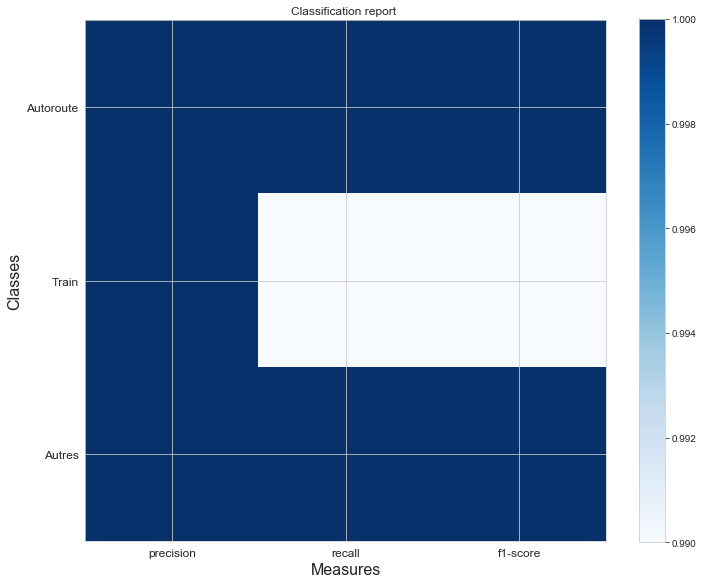

In [71]:
plot_classification_report(sampleClassificationReport)
plt.savefig('rf2_classif_report.png', dpi=200, format='png')

# Vote

In [72]:
vote_df = pd.DataFrame()
vote_df['cv0'] = test_preds[0] 
vote_df['cv1'] = test_preds[1] 
vote_df['cv2'] = test_preds[2] 
vote_df['cv3'] = test_preds[3] 
vote_df['cv4'] = test_preds[4] 

In [73]:
mask0 = pd.concat([vote_df[column] == 0 for column in vote_df], axis=1, keys=vote_df.columns)
result0 =vote_df[mask0].isnull().sum(axis=1)

mask1 = pd.concat([vote_df[column] == 1 for column in vote_df], axis=1, keys=vote_df.columns)
result1 =vote_df[mask1].isnull().sum(axis=1)

mask2= pd.concat([vote_df[column] == 2 for column in vote_df], axis=1, keys=vote_df.columns)
result2 =vote_df[mask2].isnull().sum(axis=1)

In [74]:
vote_df['sum0'] = result0
vote_df['sum1'] = result1
vote_df['sum2'] = result2

In [75]:
vote_df.shape

(2550463, 8)

In [76]:
vote_df['final_vote'] =0
vote_df['final_vote'] = np.where((vote_df['sum0'] <vote_df['sum1']) & (vote_df['sum0'] <vote_df['sum2']), 0,vote_df['final_vote'] )
vote_df['final_vote'] = np.where((vote_df['sum1'] <vote_df['sum0']) & (vote_df['sum1'] <vote_df['sum2']), 1,vote_df['final_vote'] )
vote_df['final_vote'] = np.where((vote_df['sum2'] <vote_df['sum0']) & (vote_df['sum2'] <vote_df['sum1']), 2,vote_df['final_vote'] )


In [77]:
vote_df.head(10)

,cv0,cv1,cv2,cv3,cv4,sum0,sum1,sum2,final_vote
0,0,0,0,0,0,0,5,5,0
1,0,0,0,0,0,0,5,5,0
2,0,0,0,0,0,0,5,5,0
3,0,0,0,0,0,0,5,5,0
4,0,0,0,0,0,0,5,5,0
5,0,0,0,0,0,0,5,5,0
6,0,0,0,0,0,0,5,5,0
7,0,0,0,0,0,0,5,5,0
8,0,0,0,0,0,0,5,5,0
9,0,0,0,0,0,0,5,5,0


# Submission

In [78]:
preds_ = vote_df['final_vote'].values

In [79]:
submission = pd.DataFrame()
submission['uid'] = test['uid']
submission['type'] = np.round(preds_)

In [80]:
submission.head()

,uid,type
0,"1233408,1307712",0
1,"1233592,1307896",0
2,"1233600,1307904",0
3,"1435847,1436060,1497208,1496920",0
4,"680313,5923553,682297,5921569,682339,683263,59...",0


In [81]:
uid_liste = pd.read_csv("uid_ref.csv",sep=';')
uid_liste.shape

(6610545, 2)

In [82]:
submission = submission.merge(uid_liste, left_on='uid', right_on="uid_liste", how='inner')

In [83]:
submission.head()

,uid,type,uid_liste,uids
0,"1233408,1307712",0,"1233408,1307712",1233408
1,"1233408,1307712",0,"1233408,1307712",1307712
2,"1233592,1307896",0,"1233592,1307896",1233592
3,"1233592,1307896",0,"1233592,1307896",1307896
4,"1233600,1307904",0,"1233600,1307904",1233600


In [84]:
del submission['uid']
del submission['uid_liste']
submission['uid']=submission['uids']
del submission['uids']

In [85]:
submission.head()

,type,uid
0,0,1233408
1,0,1307712
2,0,1233592
3,0,1307896
4,0,1233600


In [86]:
uc7_sub = pd.read_csv("uc7_sub.csv",sep=';')
del uc7_sub['type']

In [87]:
submission = submission.merge(uc7_sub, on='uid', how='inner')
submission.shape

(453041, 2)

In [88]:
submission.head()

,type,uid
0,0,5923595
1,0,1435045
2,1,4020425
3,2,4202295
4,2,4202125


In [89]:
 submission.to_csv("submission_uc7.csv",index=False)

## ACC test:  91.444